In [7]:
import numpy as np
import scipy.sparse as sp
import scanpy as sc
import sys
#sys.path.append("/Users/christoffer/work/karolinska/development/MANA")
#from utils import aggregate_neighbors_weighted, plot_spatial_compact_fast
import squidpy as sq
import cellcharter as cc



/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
ad_sag = sc.read_h5ad('/Volumes/processing2/KaroSpaceDataWrangle/raw/merfish/processed_mapped/adata_sagittal_mapped.h5ad')


In [6]:
# 1) Clean non-finite values first
if sp.issparse(ad_sag.X):
    ad_sag.X = ad_sag.X.tocsr()
    bad = ~np.isfinite(ad_sag.X.data)
    if bad.any():
        ad_sag.X.data[bad] = 0.0
else:
    ad_sag.X = np.nan_to_num(ad_sag.X, nan=0.0, posinf=0.0, neginf=0.0)
    ad_sag.X = sp.csr_matrix(ad_sag.X)


In [10]:
ad_sag.layers["counts"] = ad_sag.X.copy()

In [11]:
# 2) HVG should be run on log-normalized data for flavor='seurat'
sc.pp.normalize_total(ad_sag, target_sum=1e4)
sc.pp.log1p(ad_sag)

In [12]:
# 3) Run HVG
sc.pp.highly_variable_genes(ad_sag, flavor="seurat", n_top_genes=100)

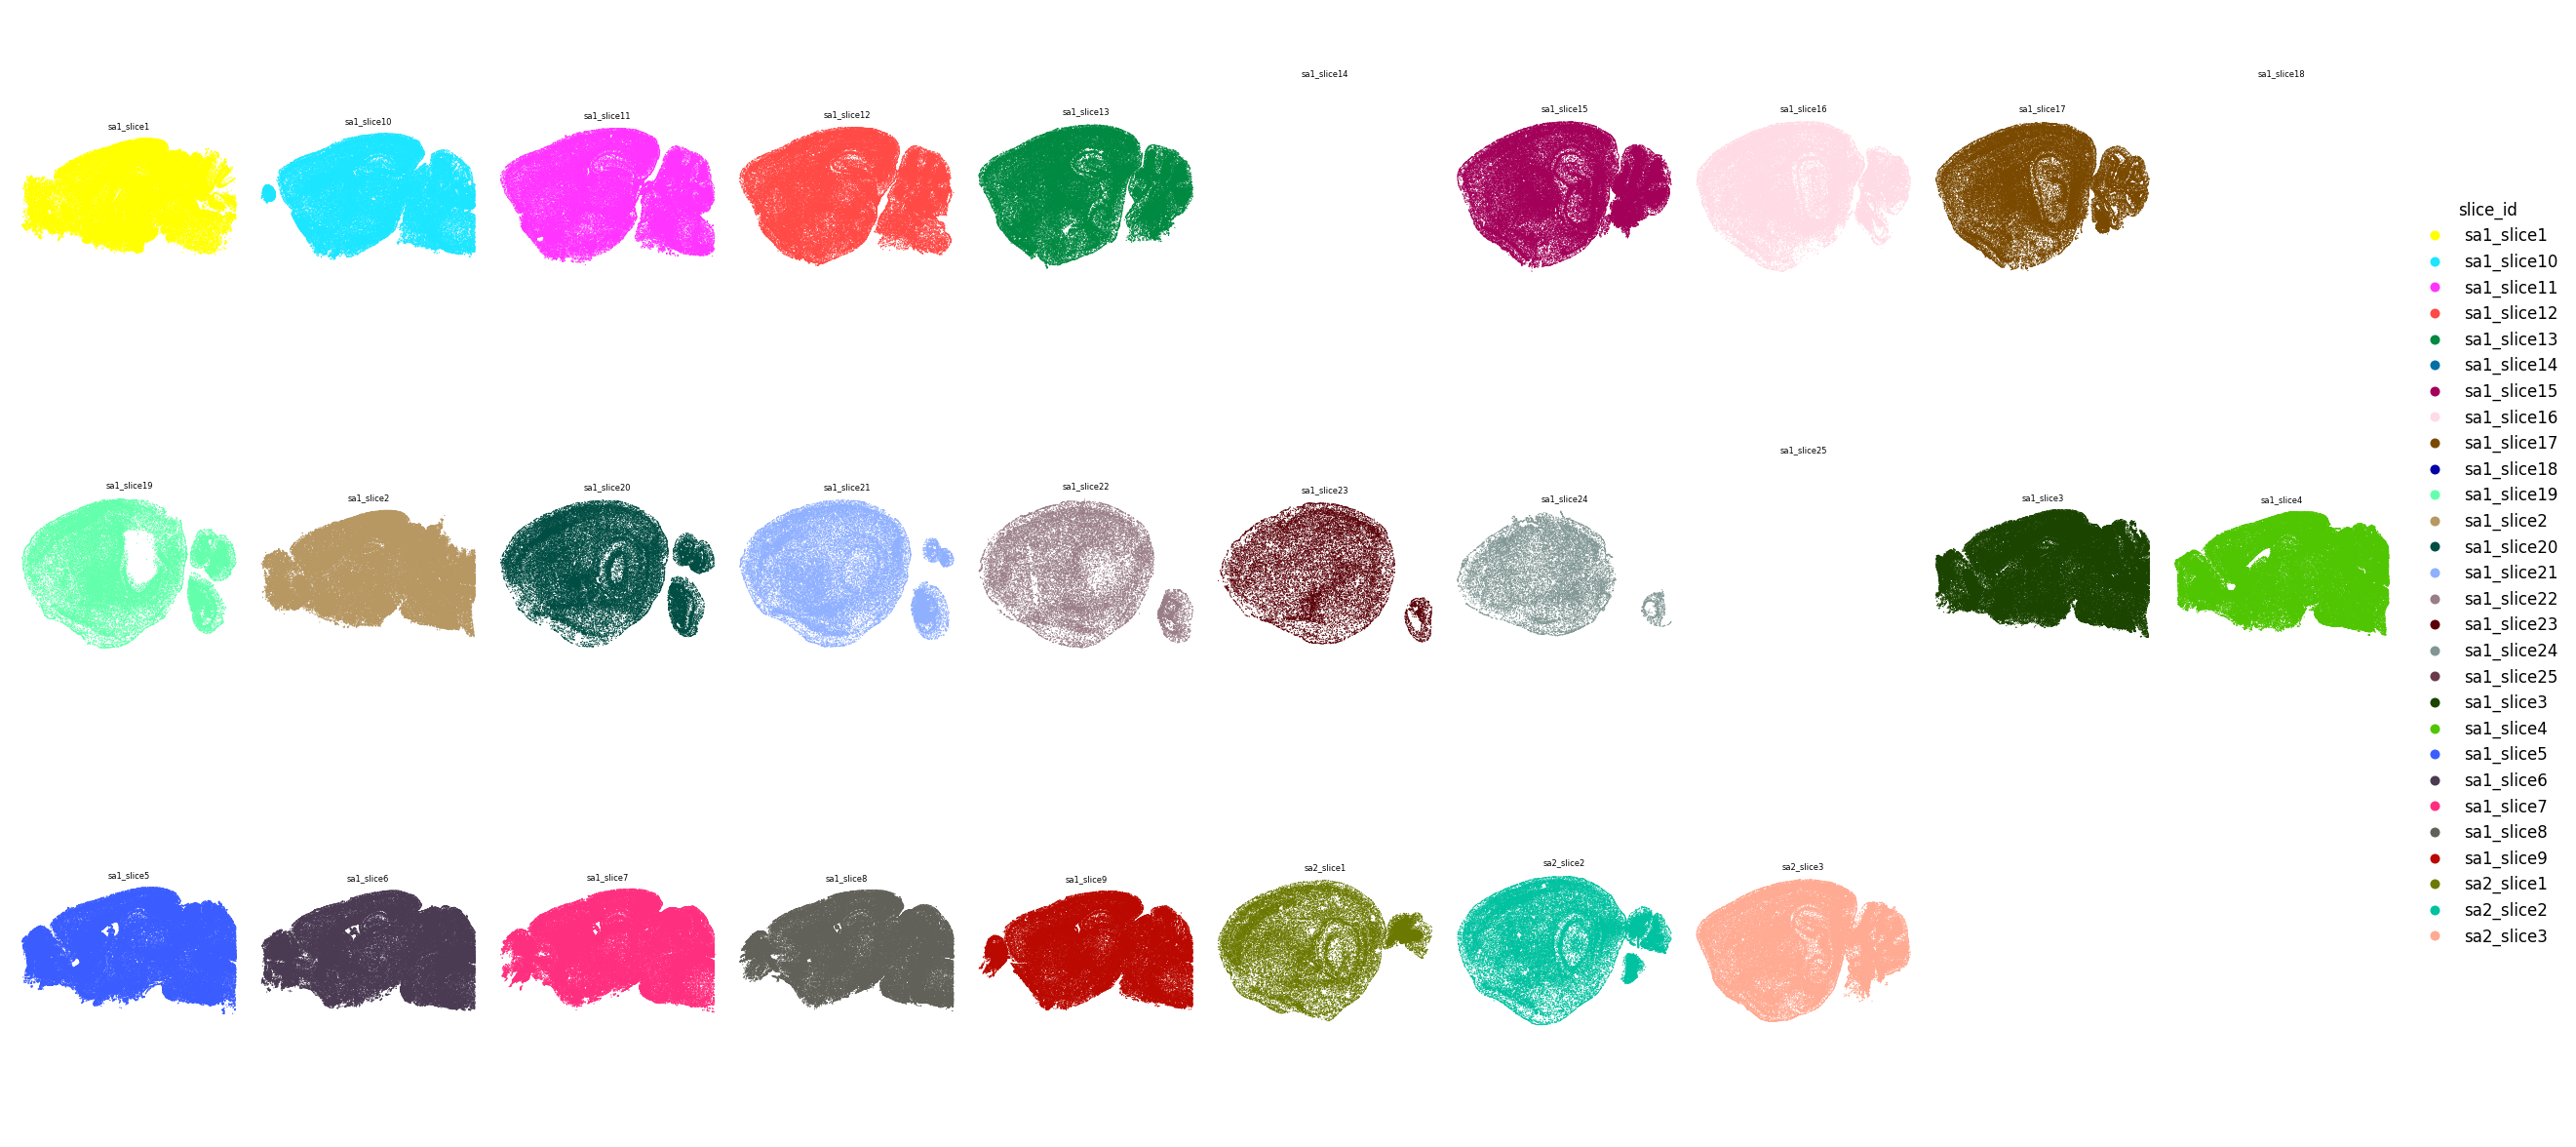

In [14]:
plot_spatial_compact_fast(
    ad_sag,
    color="slice_id",
    groupby="slice_id",
    spot_size=0.5,
    cols=10,
    height=10,
    background="white",
    dpi=120,
)

In [17]:
ad_sag.obs['slice_id'] = ad_sag.obs['slice_id'].astype(str).astype('category')
np.array(ad_sag.obs[['center_x','center_y']])
ad_sag.obsm['spatial'] = np.array(ad_sag.obs[['center_x','center_y']])
sq.gr.spatial_neighbors(ad_sag, library_key='slice_id', coord_type='generic', delaunay=True)

In [18]:
import scvi

In [19]:
ad_sub_s = ad_sag[:, ad_sag.var["highly_variable"]].copy()

scvi.model.SCVI.setup_anndata(
    ad_sub_s, 
    layer="counts", 
    batch_key='sample_id',
)

model = scvi.model.SCVI(ad_sub_s)

model.train(early_stopping=True, max_epochs = 30, enable_progress_bar=True)


/Users/christoffer/miniconda3/envs/cellcharter310/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/christoffer/miniconda3/envs/cellcharter310/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


Epoch 30/30: 100%|██████████| 30/30 [42:40<00:00, 84.55s/it, v_num=1, train_loss_step=16.3, train_loss_epoch=18.8]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 30/30: 100%|██████████| 30/30 [42:40<00:00, 85.35s/it, v_num=1, train_loss_step=16.3, train_loss_epoch=18.8]


In [20]:
# Get scVI latent representation
ad_sag.obsm['X_scVI'] = model.get_latent_representation()

print(f"Added X_scVI to ad_sag.obsm with shape: {ad_sag.obsm['X_scVI'].shape}")

Added X_scVI to ad_sag.obsm with shape: (2449745, 10)


In [36]:
import anndata as ad
import pandas as pd

ad.settings.allow_write_nullable_strings = True

for col in ad_sag.obs.columns:
    s = ad_sag.obs[col]
    if isinstance(s.dtype, pd.CategoricalDtype):
        ad_sag.obs[col] = s.cat.rename_categories(s.cat.categories.astype(str))
    elif pd.api.types.is_string_dtype(s.dtype):
        ad_sag.obs[col] = s.astype(str)

ad_sag.write("/Volumes/processing2/KaroSpaceDataWrangle/raw/merfish/processed_mapped/adata_sagittal_mapped_scVI_GMM.h5ad")


In [23]:
cc.gr.remove_long_links(ad_sag)

In [ ]:
cc.gr.aggregate_neighbors(ad_sag, n_layers=3, use_rep = 'X_scVI',  )

100%|██████████| 4/4 [00:04<00:00,  1.15s/it]


In [39]:
# GMM components to try
# GMM components to try
gmm_components = [20]

In [40]:
ad_sag

AnnData object with n_obs × n_vars = 2449745 × 1147
    obs: 'fov', 'volume', 'center_x', 'center_y', 'sample_id', 'slice_id', 'fov_x', 'fov_y', 'orientation', 'meta__brain_section_label', 'meta__feature_matrix_label', 'meta__donor_label', 'meta__donor_genotype', 'meta__donor_sex', 'meta__cluster_alias', 'meta__x', 'meta__y', 'meta__z', 'meta__subclass_confidence_score', 'meta__cluster_confidence_score', 'meta__high_quality_transfer', 'meta__abc_sample_id', 'meta__dataset', 'meta__date', 'parc__x', 'parc__y', 'parc__z', 'parc__parcellation_index', 'parc__dataset', 'parc__date', 'clu__neurotransmitter', 'clu__class', 'clu__subclass', 'clu__supertype', 'clu__cluster', 'source_file', 'gmm_CC_10', 'gmm_CC_15'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'slice_id_colors', 'spatial_neighbors', 'gmm_CC_10_colors', 'gmm_CC_15_colors'
    obsm: 'spatial', 'X_scVI', 'X_cellcharter'
    layers: 'counts'
    obsp: 'spatial_connectivities', 'spati

In [33]:
from sklearn.mixture import GaussianMixture
import pandas as pd

X = ad_sag.obsm['X_cellcharter']
gmm_results = []

for k in gmm_components:
    gmm = GaussianMixture(
        n_components=k,
        covariance_type='full',
        random_state=0,
        n_init=3,
    )
    labels = gmm.fit_predict(X)
    key = f'gmm_CC_{k}'
    ad_sag.obs[key] = labels.astype(str)
    gmm_results.append({
        'k': k,
        'bic': gmm.bic(X),
        'aic': gmm.aic(X),
    })
    n_clusters = ad_sag.obs[key].nunique()
    print(f'k={k}: {n_clusters} clusters')



/Users/christoffer/miniconda3/envs/cellcharter310/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/christoffer/miniconda3/envs/cellcharter310/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/christoffer/miniconda3/envs/cellcharter310/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/christoffer/miniconda3/envs/cellcharter310/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/christoffer/miniconda3/envs/cellcharter310/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/christoffer/miniconda3/envs/cellcharter310/lib/python3

k=15: 15 clusters


/Users/christoffer/miniconda3/envs/cellcharter310/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/christoffer/miniconda3/envs/cellcharter310/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/christoffer/miniconda3/envs/cellcharter310/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/christoffer/miniconda3/envs/cellcharter310/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/christoffer/miniconda3/envs/cellcharter310/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/christoffer/miniconda3/envs/cellcharter310/lib/python3

ValueError: Fitting the mixture model failed because some components have ill-defined empirical covariance (for instance caused by singleton or collapsed samples). Try to decrease the number of components, increase reg_covar, or scale the input data. The numerical accuracy can also be improved by passing float64 data instead of float32.

In [41]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

X_raw = np.asarray(ad_sag.obsm["X_cellcharter"], dtype=np.float64)
if not np.isfinite(X_raw).all():
    raise ValueError("X_cellcharter contains NaN or inf values")

# Stabilize GMM fitting
X = StandardScaler().fit_transform(X_raw)

gmm_results = []

for k in gmm_components:
    if k >= X.shape[0]:
        print(f"k={k}: skipped (n_components must be < n_samples={X.shape[0]})")
        continue

    fitted = False
    last_err = None

    # Try increasingly stronger regularization; fallback to diag if full fails
    for cov_type in ("full", "diag"):
        for reg in (1e-6, 1e-5, 1e-4, 1e-3, 1e-2):
            try:
                gmm = GaussianMixture(
                    n_components=k,
                    covariance_type=cov_type,
                    reg_covar=reg,
                    random_state=0,
                    n_init=10,
                    max_iter=500,
                    init_params="kmeans",
                )
                labels = gmm.fit_predict(X)

                key = f"gmm_CC_{k}"
                ad_sag.obs[key] = pd.Categorical(labels.astype(str))

                gmm_results.append(
                    {
                        "k": k,
                        "bic": gmm.bic(X),
                        "aic": gmm.aic(X),
                        "covariance_type": cov_type,
                        "reg_covar": reg,
                        "converged": gmm.converged_,
                        "n_iter": gmm.n_iter_,
                    }
                )

                n_clusters = ad_sag.obs[key].nunique()
                print(
                    f"k={k}: {n_clusters} clusters "
                    f"(cov={cov_type}, reg={reg}, converged={gmm.converged_})"
                )
                fitted = True
                break
            except ValueError as e:
                last_err = e
        if fitted:
            break

    if not fitted:
        print(f"k={k}: failed ({last_err})")
        gmm_results.append(
            {
                "k": k,
                "bic": np.nan,
                "aic": np.nan,
                "covariance_type": None,
                "reg_covar": None,
                "converged": False,
                "n_iter": 0,
                "error": str(last_err),
            }
        )

gmm_results_df = pd.DataFrame(gmm_results).sort_values("bic", na_position="last")


/Users/christoffer/miniconda3/envs/cellcharter310/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/christoffer/miniconda3/envs/cellcharter310/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/christoffer/miniconda3/envs/cellcharter310/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/christoffer/miniconda3/envs/cellcharter310/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/christoffer/miniconda3/envs/cellcharter310/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/christoffer/miniconda3/envs/cellcharter310/lib/python3

KeyboardInterrupt: 

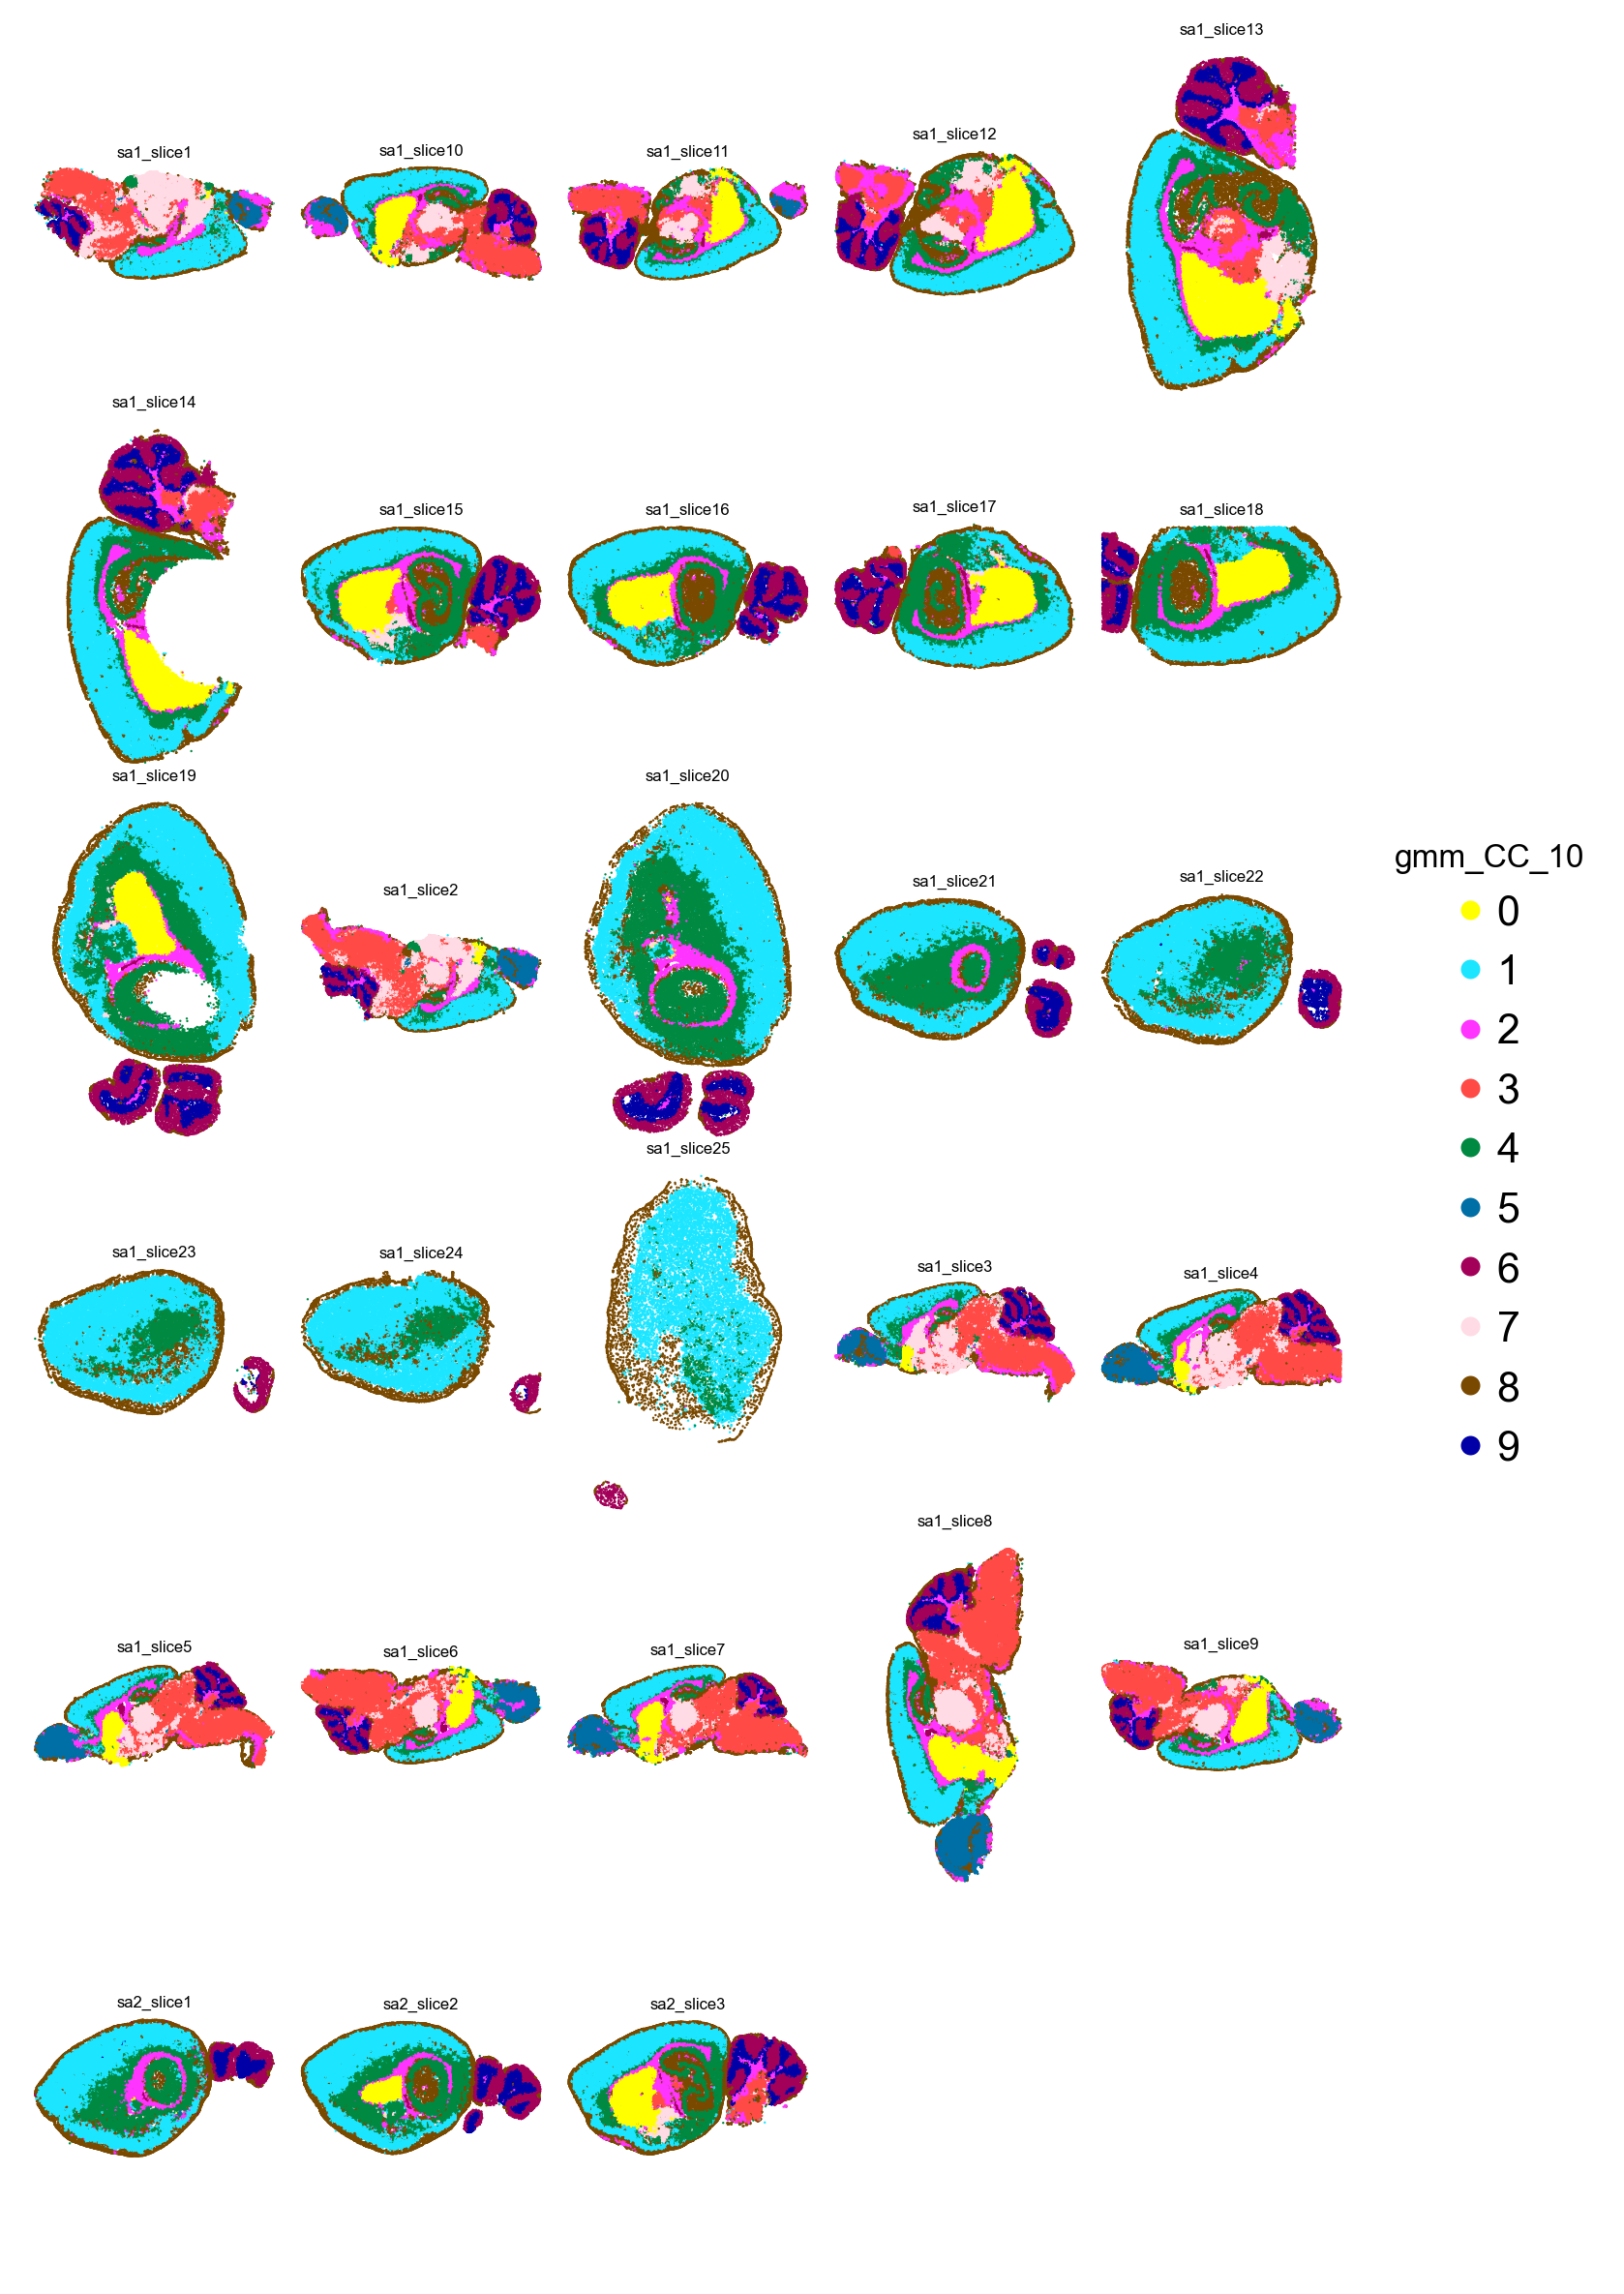

In [30]:
plot_spatial_compact_fast(
    ad_sag,
    color="gmm_CC_10",
    groupby="slice_id",
    spot_size=0.5,
    cols=5,
    height=10,
    background="white",
    dpi=120,
)

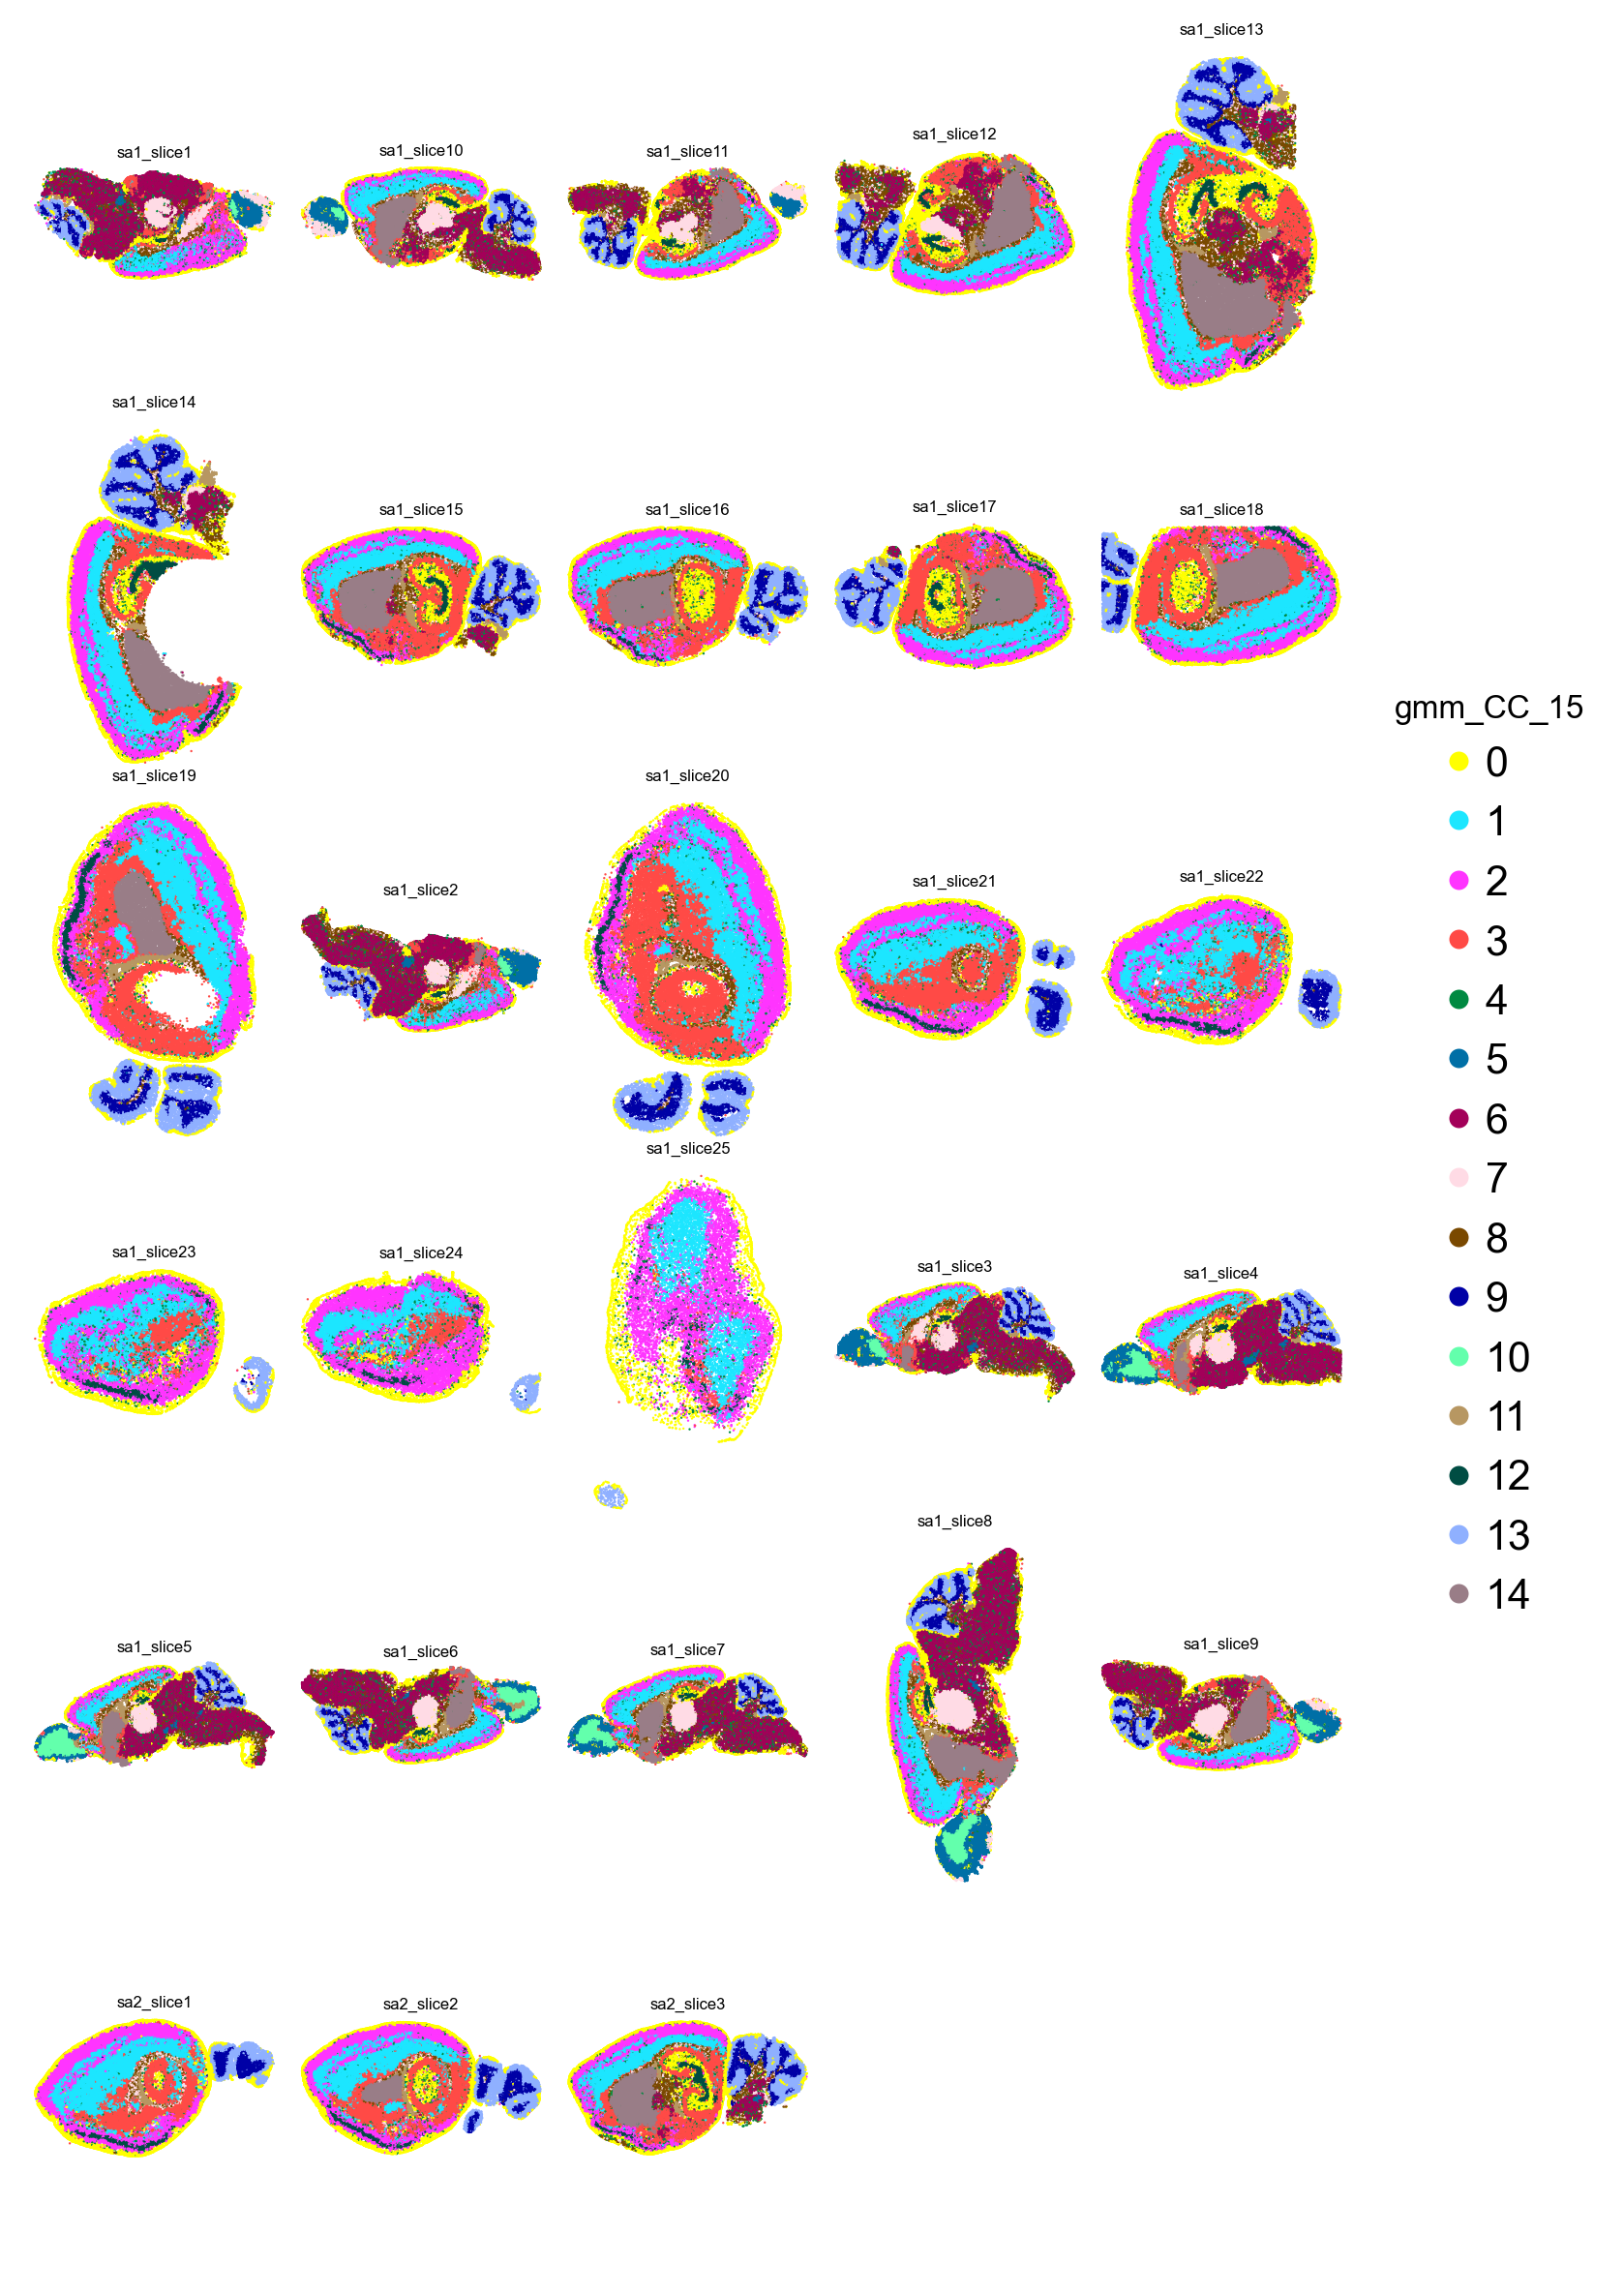

In [ ]:
plot_spatial_compact_fast(
    ad_sag,
    color="gmm_CC_15",
    groupby="slice_id",
    spot_size=0.5,
    cols=5,
    height=10,
    background="white",
    dpi=120,
)

In [ ]:
plot_spatial_compact_fast(
    ad_sag,
    color="gmm_CC_20",
    groupby="slice_id",
    spot_size=0.5,
    cols=5,
    height=10,
    background="white",
    dpi=120,
)

In [1]:
import scanpy as sc

/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [2]:
ad = sc.read_h5ad('/Volumes/processing2/KaroSpaceDataWrangle/raw/merfish/processed_mapped/adata_sagittal_mapped_scVI_GMM.h5ad')

In [9]:
ad.layers['counts'] = sp.csr_matrix(ad.layers['counts'])

In [10]:
ad.X = sp.csr_matrix(ad.X)

In [23]:
import anndata as adt
import pandas as pd

adt.settings.allow_write_nullable_strings = True

for col in ad.obs.columns:
    s = ad.obs[col]
    if isinstance(s.dtype, pd.CategoricalDtype):
        ad.obs[col] = s.cat.rename_categories(s.cat.categories.astype(str))
    elif pd.api.types.is_string_dtype(s.dtype):
        ad.obs[col] = s.astype(str)

ad.write('/Volumes/processing2/KaroSpaceDataWrangle/raw/merfish/processed_mapped/adata_sagittal_mapped_scVI_GMM.h5ad')


In [16]:
ad.obs.sample_id = ad.obs.sample_id.astype(str)

In [18]:
del ad.obs.sample_id

AttributeError: 'DataFrame' object has no attribute 'sample_id'

In [21]:
ad.obs = ad.obs.drop(columns = 'sample_id')